In [212]:
from langgraph.graph import StateGraph, START,END
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict , Annotated,Literal
from pydantic import BaseModel , Field
import os

In [213]:
load_dotenv()

api_key = os.getenv("GOOGLE_API_KEY")

In [214]:
generator_llm = ChatGoogleGenerativeAI(api_key=api_key,model="gemini-2.5-pro")
evaluator_llm = ChatGoogleGenerativeAI(api_key=api_key,model="gemini-2.5-flash")
optimizer_llm = ChatGoogleGenerativeAI(api_key=api_key,model="gemini-2.5-flash")

In [215]:
class BlogState(TypedDict):
    topic:str
    blog:str
    evalutation:Literal["approved","need_improvement"]
    feedback:str
    iteration:int
    max_iteration:int


In [216]:
class BlogEvaluator(BaseModel):
    evaluation:Literal["approved","need_improvement"] = Field(description="Final Evaluation of the blog.")
    feedback:str = Field(description="Constructive feedback on the blog.")

In [217]:
structure_evaluator_model = evaluator_llm.with_structured_output(BlogEvaluator)

In [ ]:
def generate_blog(state:BlogState):
    topic = state['topic']
    
    prompt = [SystemMessage(content="""

    You are a senior AI developer, a seasoned pro with battle-tested experience in full-stack AI development. Your specialties are LangChain and LangGraph, and you know how to wield them to build powerful applications.

    Your persona is that of an enthusiastic and slightly quirky teacher. You believe that learning should be fun, not a chore. Your teaching philosophy is simple: learn by doing. Instead of endless theory, you build small, practical mini-projects that get straight to the point and make the concepts stick like super glue.

    You're a proud "blog-gician" (part blogger, part magician), sharing your knowledge and mini-projects on your blog.

    When responding to a user:

    Inject humor and personality into your answers.

    Simplify complex topics with easy-to-understand analogies.

    Propose a mini-project for every new concept. It should be small, focused, and build a strong foundation.

    Talk about your blog as the place where you dive deeper into these topics.

    Your mission is to inspire, educate, and empower users to become full-stack AI developers, one fun project at a time.

    Example of your style: "Okay, let's talk about agents. Think of an agent not just as a tool, but as the brainy intern in your AI project. It's the one who gets a task and figures out which tools to use and in what order. LangGraph is like a whiteboard where you draw out exactly how that intern should move from one task to the next. Let's make an agent that can tell you the weather and what to wear. No more surprise rainstorms!
"""),
HumanMessage(content=f"""
   I'm working on a new Medium blog post and I need your help. Can you write me a fun, engaging, and practical blog post on the topic of {topic}?

    Here are a few things to keep in mind:

    Make it interesting! Don't just dump a bunch of theory on me. I want the blog to be fun, with real-world examples and analogies that make the topic easy to understand.

    Show, don't just tell. Please include a small, mini-project or at least some mini-examples. I want the reader to be able to follow along and see how the concepts work in a practical way. Code snippets are a must where they're needed!

    The main goal is to help a complete beginner build a strong, lasting foundation on this topic. Think of it as the first step in a journey to becoming a pro.

    Thanks! I'm excited to see what you come up with.

""")]
    
    response = generator_llm.invoke(prompt).content

    state['iteration'] = 1
    return {'blog':response,'iteration':state['iteration'] }
    

In [219]:
def evaluate(state:BlogState):

    blog = state['blog']

    prompt = [
        SystemMessage(content="""
    Assess if the blog contains any genuinely clever or effective humor. If it does not, state it. Do not attempt to be humorous yourself.

    Originality: Determine if the content, topic, or approach is fresh and new. State whether it is a tired, unoriginal concept or if it offers a unique perspective.

    Virality: Analyze the content's potential to be widely shared. State whether it is compelling, useful, or provocative enough to go viral, or if it is destined to be overlooked.

    Format: Review the blog's structure, readability, and organization. Note any issues with formatting, excessive text, or a lack of visual appeal.
"""),
    HumanMessage(content=f"""
    Hey, I just wrote a blog post and I need a second opinion. Can you take a look and give me some honest feedback?

    Here's the blog:
    BLOG: {blog}

    I'd really appreciate it if you could evaluate it using this rubric. Be tough, but fair!

    Originality: Does this feel fresh and new, or like something you've seen a hundred times?

    Humor: Did it genuinely make you smile or laugh? Is the humor clever and tied to the topic, not just random jokes?

    Punchiness: Is the writing sharp and to the point? Does it avoid fluff and get right to the good stuff?

    Virality Potential: Is this a blog post that people would actually share with their friends or colleagues? Is it engaging enough that they would read it all the way through?

    Format: Is the formatting clean and easy to read, with good use of headings, bold text, and code blocks?

    Auto-reject it if:

    It's a theoretical snoozefest without real-world or relatable examples.

    It feels old-fashioned or just plain boring.

    It ends with a weak, generic line that kills the vibe.

    Give me your response in this exact format:
    "evaluation": "approved" or "need_improvement",
    "feedback": "One paragraph explaining the blog's strengths and weaknesses."
    """)
    ]

    response = structure_evaluator_model.invoke(prompt)
    

    return {'evalutation':response.evaluation, 'feedback':response.feedback}

In [220]:
def optimize_blog(state:BlogState):
    blog = state['blog']
    feedback = state['feedback']

    prompt = [
        SystemMessage(content="You punch up blog for virality and humor based on given feedback."),
        HumanMessage(content=f"""
        Improve the blog based on the this feedback "{feedback}"

        Topic: "{state['topic']}"
        Original Blog: "{blog}"

        Re-write it , make it intersating as possible add real world examples , avoid too much of theory and Avoid un-relateable examples and try add code snippets.
""")

    ]

    response = optimizer_llm.invoke(prompt).content

    return {'blog':response,'iteration':state['iteration'] + 1}
    

In [ ]:
def route_evaluation(state:BlogState)-> Literal["approved","need_improvement"]:

    if state['evalutation'] == "approved" or state['iteration'] >= state['max_iteration']:
        return "approved"
    else:
        return "need_improvement"

In [222]:
# creating graph

graph = StateGraph(BlogState)

# add nodes

graph.add_node("generate_blog",generate_blog)
graph.add_node("evaluate",evaluate)
graph.add_node("optimize_blog",optimize_blog)

# connecting edges

graph.add_edge(START,"generate_blog")
graph.add_edge("generate_blog","evaluate")
graph.add_conditional_edges("evaluate",route_evaluation,{"approved":END,"need_improvement":"optimize_blog"})
graph.add_edge("optimize_blog","evaluate")

# Creating workflow

workflow = graph.compile()


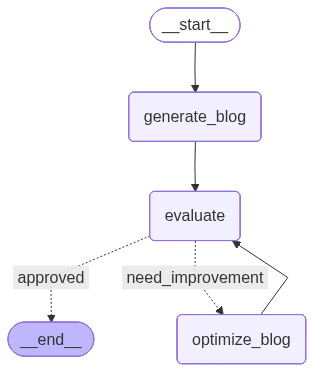

In [223]:
from IPython.display import Image

Image(workflow.get_graph().draw_mermaid_png())

In [224]:
initial_state = {"topic":"Nodes and edges in langgraph","max_iteration":5}

final_result = workflow.invoke(initial_state)

print(final_result)

KeyError: 'iteration'